<a href="https://colab.research.google.com/github/quancore/toxic-comment/blob/master/pytorch_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
!python pytorch-xla-env-setup.py --version 20200420 --apt-packages libomp5 libopenblas-dev > /dev/null
!pip install transformers==2.5.1 > /dev/null
!pip install pandarallel > /dev/null
!pip install catalyst==20.4.2 > /dev/null
!pip install kaggle

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3727  100  3727    0     0  63169      0 --:--:-- --:--:-- --:--:-- 63169
Copying gs://tpu-pytorch/wheels/torch-nightly+20200420-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 86.8 MiB/ 86.8 MiB]                                                
Operation completed over 1 objects/86.8 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200420-cp36-cp36m-linux_x86_64.whl...
- [1 files][117.2 MiB/117.2 MiB]                                                
Operation completed over 1 objects/117.2 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200420-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  2.4 MiB/  2.4 MiB]                                                
Operation completed over 1 objects/2.4 MiB.                                      
ERROR:

In [0]:
# arr=[]
# while(1):
#  arr.append(1)

In [3]:
%load_ext autoreload
%autoreload 2 

from google.colab import drive

drive.mount("/content/drive", force_remount=True)

import sys
sys.path.append('drive/My Drive/toxic_comment/scripts')

import os
os.environ['XLA_USE_BF16'] = "1"

import gc
import time
from pathlib import Path
from importlib import reload

import utility as utils
import albumentations as alb
import data_cleaning as clean
import models
import config

reload(utils)
reload(alb)
reload(clean)
reload(models)
reload(config)


import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel

import torch
from torch.utils.data import DataLoader
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
from catalyst.data.sampler import DistributedSamplerWrapper, BalanceClassSampler

pandarallel.initialize(nb_workers=4, progress_bar=False)

Mounted at /content/drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [0]:
MODEL = 'xlm-roberta-large'
MODEL_VERSION = 'v1'
MAX_LENGTH = 224

root_dir = "drive/My Drive/toxic_comment"

# *Data access
data_dir = Path(root_dir, "data")
data_t_dir = data_dir/"jigsaw-toxic/translations"

# *Model paths
model_dir = Path(root_dir, "models")

# *Files
train_file1 = "jigsaw-toxic/jigsaw-toxic-comment-train.csv"
train_file2 = "jigsaw-toxic/jigsaw-unintended-bias-train.csv"
val_file = "jigsaw-toxic/validation.csv"
test_file = "jigsaw-toxic/test.csv"
sub_file = "jigsaw-toxic/sample_submission.csv"
open_subtitles_file = 'open-subtitles-toxic/open-subtitles-synthesic.csv'

out_dir = Path(root_dir, 'output')

LANGS = {
    'en': 'english',
    'it': 'italian', 
    'fr': 'french', 
    'es': 'spanish',
    'tr': 'turkish', 
    'ru': 'russian',
    'pt': 'portuguese'
}

In [5]:
%%time
# Read the data
dir_dict = {'base_dir': data_dir, 'base_t_dir': data_t_dir, 'train_file1': train_file1, 
            'train_file2': train_file2, 'val_file': val_file, 'test_file': test_file, 'sub_file': sub_file}
train, valid, test, sub = utils.read_data(dir_dict, list(LANGS.keys()))

CPU times: user 46.5 s, sys: 7.43 s, total: 53.9 s
Wall time: 1min 12s


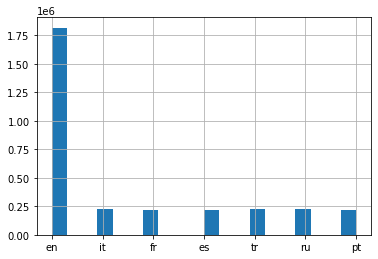

In [6]:
train['lang'].hist(bins=20);

In [0]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [0]:
train_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=train['toxic'].values, 
    comment_texts=train['comment_text'].values, 
    langs=train['lang'].values,
    lang_dict=LANGS,
    open_subtitles_path=data_dir/open_subtitles_file,
    maxlen=MAX_LENGTH,
    use_train_transforms=True,
)

del train
gc.collect();

In [0]:
input_cols_dev = ['comment_text']

validation_tune_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=valid['toxic'].values, 
    comment_texts=valid[input_cols_dev].values, 
    langs=valid['lang'].values,
    lang_dict=LANGS,
    open_subtitles_path=data_dir/open_subtitles_file,
    maxlen=MAX_LENGTH,
    use_train_transforms=True,
)

valid = clean.clean_data(valid, input_cols_dev, LANGS)

validation_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=valid['toxic'].values, 
    comment_texts=valid[input_cols_dev].values, 
    langs=valid['lang'].values,
    maxlen=MAX_LENGTH,
    use_train_transforms=False,
)

del valid
gc.collect();

In [0]:
input_cols_test = ['content']
test = clean.clean_data(test, input_cols_test, LANGS)

test_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=test.index.values, 
    comment_texts=test[input_cols_test].values, 
    langs=test['lang'].values,
    maxlen=MAX_LENGTH,
    use_train_transforms=False,
    test=True
)

del test
gc.collect();

In [0]:
transformer = AutoModel.from_pretrained(MODEL)

In [0]:
net = models.ToxicSimpleNNModel(transformer)

In [13]:
net

ToxicSimpleNNModel(
  (backbone): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerN

In [0]:
import warnings
warnings.filterwarnings("ignore")

def _mp_fn(rank, flags):
    device = xm.xla_device()
    net.to(device)

    train_sampler = DistributedSamplerWrapper(
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=train_sampler,
        pin_memory=False,
        drop_last=True,
        num_workers=config.TrainGlobalConfig.num_workers,
    )
    validation_sampler = torch.utils.data.distributed.DistributedSampler(
        validation_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=validation_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=config.TrainGlobalConfig.num_workers
    )
    validation_tune_sampler = torch.utils.data.distributed.DistributedSampler(
        validation_tune_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    validation_tune_loader = torch.utils.data.DataLoader(
        validation_tune_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=validation_tune_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=config.TrainGlobalConfig.num_workers
    )
    test_sampler = torch.utils.data.distributed.DistributedSampler(
        test_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=test_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=config.TrainGlobalConfig.num_workers
    )
    if rank == 0:
        time.sleep(1)
    
    fitter = models.TPUFitter(model=net, device=device, config=config.TrainGlobalConfig, 
                              base_model_path=model_dir, model_name=MODEL, model_version=MODEL_VERSION, out_path=out_dir)
    fitter.fit(train_loader, validation_loader)
    for val_epoch in range(2):
      fitter.run_validation_tuning(validation_tune_loader, val_epoch)

In [15]:
FLAGS={}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

**** Directory structure created ****
Fitter prepared. Device is xla:1
**** Fitting process has been started ****

2020-05-14T13:11:51.520004
LR: 4e-05 
Epoch:0
**** Epoch training has started: 0 ****
Train Step 0, loss: 0.00000, final_score: 0.00000, time: 0.92831
Train Step 50, loss: 0.54656, final_score: 0.83387, time: 200.87250
Train Step 100, loss: 0.47513, final_score: 0.89875, time: 253.25266
Train Step 150, loss: 0.43087, final_score: 0.92735, time: 305.44174
Train Step 200, loss: 0.41061, final_score: 0.93877, time: 357.87136
Train Step 250, loss: 0.40007, final_score: 0.94435, time: 410.63996
Train Step 300, loss: 0.39041, final_score: 0.94888, time: 463.31462
Train Step 350, loss: 0.38379, final_score: 0.95208, time: 515.99540
Train Step 400, loss: 0.37535, final_score: 0.95585, time: 568.44868
Train Step 450, loss: 0.36853, final_score: 0.95891, time: 620.92501
Train Step 500, loss: 0.36286, final_score: 0.96133, time: 673.56036
Train Step 550, loss: 0.36049, final_score: 0

In [29]:
tokenizer.save_pretrained((model_dir/MODEL/MODEL_VERSION))
transformer.save_pretrained((model_dir/MODEL/MODEL_VERSION))

('drive/My Drive/toxic_comment/models/xlm-roberta-large/v1/sentencepiece.bpe.model',
 'drive/My Drive/toxic_comment/models/xlm-roberta-large/v1/special_tokens_map.json',
 'drive/My Drive/toxic_comment/models/xlm-roberta-large/v1/added_tokens.json')

In [34]:
os.environ["KAGGLE_USERNAME"] = creds['username']
os.environ["KAGGLE_KEY"] = creds['key']

from kaggle.api.kaggle_api_extended import KaggleApi
new_model = {
  "title": f"{MODEL}", 
  "description": "Trained model for toxic comment challange",
  "id": f"quanncore/{MODEL.lower()}", 
  "licenses": [{"name": "CC0-1.0"}],
  "resources": [
    {
      "path": "last-checkpoint.bin",
      "description": "Saved model file"
    },
    {
      "path": "sentencepiece.bpe.model",
      "description": "sentencepiece model"
    },
    {
      "path": "special_tokens_map.json",
      "description": "Special token map"
    },
    {
      "path": "tokenizer_config.json",
      "description": "Tokenizer config"
    },
    {
      "path": "config.json",
      "description": "Model config"
    }
  ],
}

def update_model_kaggle():
  api = KaggleApi()
  api.authenticate()

  dataset_dir = (model_dir/MODEL/MODEL_VERSION)
  dataset_id = f"quanncore/{MODEL.lower()}"
  with open((dataset_dir/'dataset-metadata.json'), 'w') as fp:
    json.dump(new_model, fp)
  
  response = api.dataset_status(dataset_id)
  if response == None:
    print('Creating a new dataset\n')
    api.dataset_create_new(dataset_dir)
  else:
    print(f'Got response: {response}\n. Creating a new version\n')
    api.dataset_create_version(dataset_dir, version_notes=f'new version: {MODEL_VERSION.lower()}')



update_model_kaggle()

  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Got response: ready
. Creating a new version

Starting upload for file last-checkpoint.bin


100%|██████████| 2.09G/2.09G [00:47<00:00, 47.0MB/s]
  0%|          | 0.00/39.8k [00:00<?, ?B/s]

Upload successful: last-checkpoint.bin (2GB)
Starting upload for file log.txt


100%|██████████| 39.8k/39.8k [00:01<00:00, 35.4kB/s]


Upload successful: log.txt (40KB)
Starting upload for file tokenizer_config.json


100%|██████████| 16.0/16.0 [00:03<00:00, 5.01B/s]
  0%|          | 0.00/150 [00:00<?, ?B/s]

Upload successful: tokenizer_config.json (16B)
Starting upload for file special_tokens_map.json


100%|██████████| 150/150 [00:01<00:00, 97.8B/s]
  0%|          | 0.00/4.83M [00:00<?, ?B/s]

Upload successful: special_tokens_map.json (150B)
Starting upload for file sentencepiece.bpe.model


100%|██████████| 4.83M/4.83M [00:01<00:00, 4.08MB/s]
  0%|          | 0.00/1.02k [00:00<?, ?B/s]

Upload successful: sentencepiece.bpe.model (5MB)
Starting upload for file config.json


100%|██████████| 1.02k/1.02k [00:00<00:00, 1.16kB/s]
  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Upload successful: config.json (1KB)
Starting upload for file pytorch_model.bin


100%|██████████| 2.09G/2.09G [00:28<00:00, 77.8MB/s]


Upload successful: pytorch_model.bin (2GB)
